# Inference: Body Mass Index Relation to Being Diabetic

## Introduction

Diabetes is a prevalent disease which has dramatically increased in recent years. With modern farming methods and key insight into food nutrition, it would be assumed that the general population is seemingly healthy. However, obesity is on the rise and we will investigate the relationship between the two increasing trends. 

Obesity is quantified through body mass index (BMI) which takes into account a person's height and weight to measure if an individual is healthy. Ideally an individual will be in the range of 18.5 to 24.9 . In the US, over 7% of the population is diabetic whereas 35.7% is obese. 

Although significant research has been done on how BMI is an underlying factor of diabetes, we aim to obtain a quantifiable number in the difference in BMI between a diabetic and nondiabetic. This would lead to a better understanding in the association of BMI and being diabetic which can be applied to further research. 

Thus, our research question is : **Is the average (mean) BMI value of people with diabetes higher than those who do not have diabetes?**
 
The dataset will be split into two groups according to if the individual has diabetes. The mean BMI of the two groups will then be compared in order to determine if people with diabetes are higher than those who do not have diabetes using bootstrapping. The hypothesis will be that the mean BMI value of the diabetic group will be higher than the non-diabetic group. This will be explored on  our Diabetes and Digestive dataset obtained from the National Institute of Diabetes and Digestive and Kidney Diseases. The participants were females at least 21 years old. Firstly, the data will be cleaned to only focus on the variables outcome and BMI. Outcome is a Boolean and the group will be split on whether they are “TRUE” for having diabetes or “FALSE”. The BMI variable will be used to obtain the mean following other testing through bootstrapping to obtain the confidence interval. 


## Preliminary Results

In [112]:
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)

In [113]:
set.seed(999)
options(repr.plot.width = 15, repr.plot.height = 10) 

In [114]:
# dataset read from the web ------------------------------------------------------------
diabetes <- read_csv('https://raw.githubusercontent.com/Kayleeli/STAT201-Group-23/main/data/diabetes.csv') 
head(diabetes, n = 2)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): pregnancies, glucose, bloodpressure, skinthickness, insulin, bmi, d...
lgl (1): outcome

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
6,148,72,35,0,33.6,0.627,50,TRUE
1,85,66,29,0,26.6,0.351,31,FALSE


In [106]:
# clean + wrangled the data into tidy format ------------------------------------------

    # because we only want to focus on the relationship between bmi + outcome, selecting only:
        # 1) bmi column : body mass index in kg/m^2
        # 2) outcome column : TRUE = diabetic , FALSE = Non-diabetic

diabetes <- diabetes %>%
    select(bmi, outcome)

head(diabetes, n = 2)

bmi,outcome
<dbl>,<lgl>
33.6,TRUE
26.6,FALSE


In [93]:
# plot relevant data + compute estimates of the parameter identified -------------------

    # splitting people into 2 groups based on "outcome" (TRUE (diabetic) vs FALSE (non-diabetic))

diabetic_group <- diabetes %>%
    filter(outcome=="TRUE") %>%
    select(bmi)

nondiabetic_group <- diabetes %>%
    filter(outcome=="FALSE") %>%
    select(bmi)

head(diabetic_group, n = 2)
head(nondiabetic_group, n = 2)

bmi
<dbl>
33.6
23.3


bmi
<dbl>
26.6
28.1


In [107]:
# POPULATION PARAMETER

    # mean bmi values for people who are diabetic in this dataset
    diabetic_group_mean <- diabetic_group %>%
        summarize(mean = mean(bmi)) %>%
        pull()

    # mean bmi values for people who are non-diabetic in this dataset
    nondiabetic_group_mean <- nondiabetic_group %>%
        summarize(mean = mean(bmi)) %>%
        pull()

    # difference in mean bmi for people with and without diabetes in this dataset
    difference_in_mean_pop <- diabetic_group_mean - nondiabetic_group_mean

    # summary of the population parameter above into a dataframe

    pop_parameter_summary <- matrix(c(diabetic_group_mean, nondiabetic_group_mean, difference_in_mean_pop), ncol = 3, byrow = TRUE) 
    colnames(pop_parameter_summary) <- c("Mean BMI (Diabetic)", "Mean BMI (Non-Diabetic)", "Difference in BMI ((Diabetic)-(Non-Diabetic))")
    rownames(pop_parameter_summary) <- c('Values (in kg/m^2)')
    table_pop_parameter_summary <- as.data.frame(pop_parameter_summary)

# POPULATION PARAMETER VALUES (SUMMARY)
table_pop_parameter_summary

,Mean BMI (Diabetic),Mean BMI (Non-Diabetic),Difference in BMI ((Diabetic)-(Non-Diabetic))
,<dbl>,<dbl>,<dbl>
Values (in kg/m^2),35.14254,30.3042,4.838337


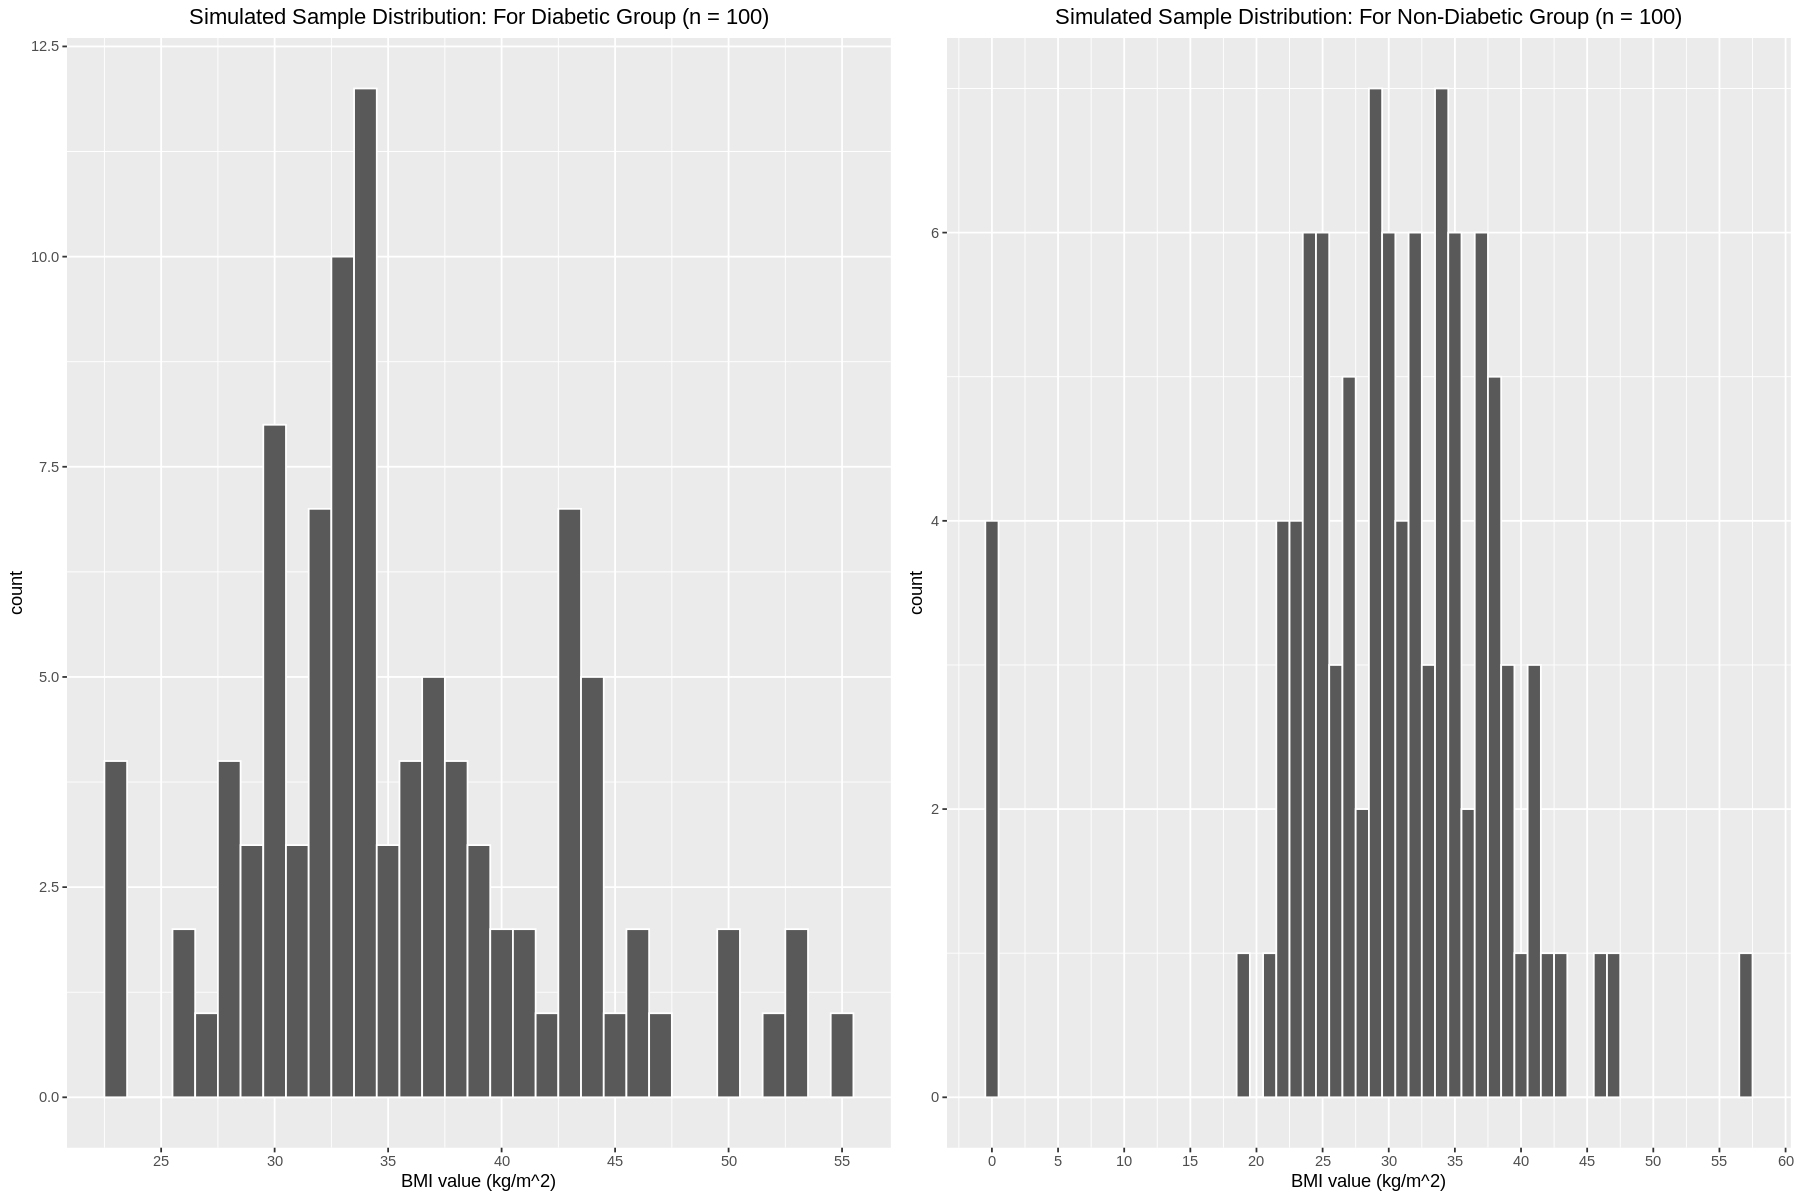

In [115]:
# SAMPLE DISTRIBUTION

    # For: diabetic_group : We randomly create a single sample, size 100, from diabetic_group 

    sample_diabetic <- diabetic_group %>%
        rep_sample_n(size=100, reps=1, replace=FALSE) %>%
        ungroup()  

        ## Histogram : Simulated SAMPLE Distribution <diabetic>

        diabetics_sample_hist <- sample_diabetic %>%
                ggplot(aes(x=bmi))+
                geom_histogram(binwidth=1, color="white")+
                labs(x="BMI value (kg/m^2)")+
                ggtitle("Simulated Sample Distribution: For Diabetic Group (n = 100)") +
                theme(plot.title = element_text(hjust = 0.5)) +
                scale_x_continuous(breaks=seq(0,60, 5))

    # For: non-diabetic_group : We randomly create a single sample, size 100, from nondiabetic_group 

    sample_nondiabetic <- nondiabetic_group %>%
        rep_sample_n(size=100, reps=1, replace=FALSE) %>%
        ungroup()

        ## Histogram : Simulated SAMPLE Distribution <non-diabetic>

        nondiabetics_sample_hist <- sample_nondiabetic %>%
                ggplot(aes(x=bmi))+
                geom_histogram(binwidth=1, color="white")+
                labs(x="BMI value (kg/m^2)")+
                ggtitle("Simulated Sample Distribution: For Non-Diabetic Group (n = 100)") +
                theme(plot.title = element_text(hjust = 0.5)) +
                scale_x_continuous(breaks=seq(0,60, 5))


# Histogram of SAMPLE distribution
plot_grid(diabetics_sample_hist, nondiabetics_sample_hist)

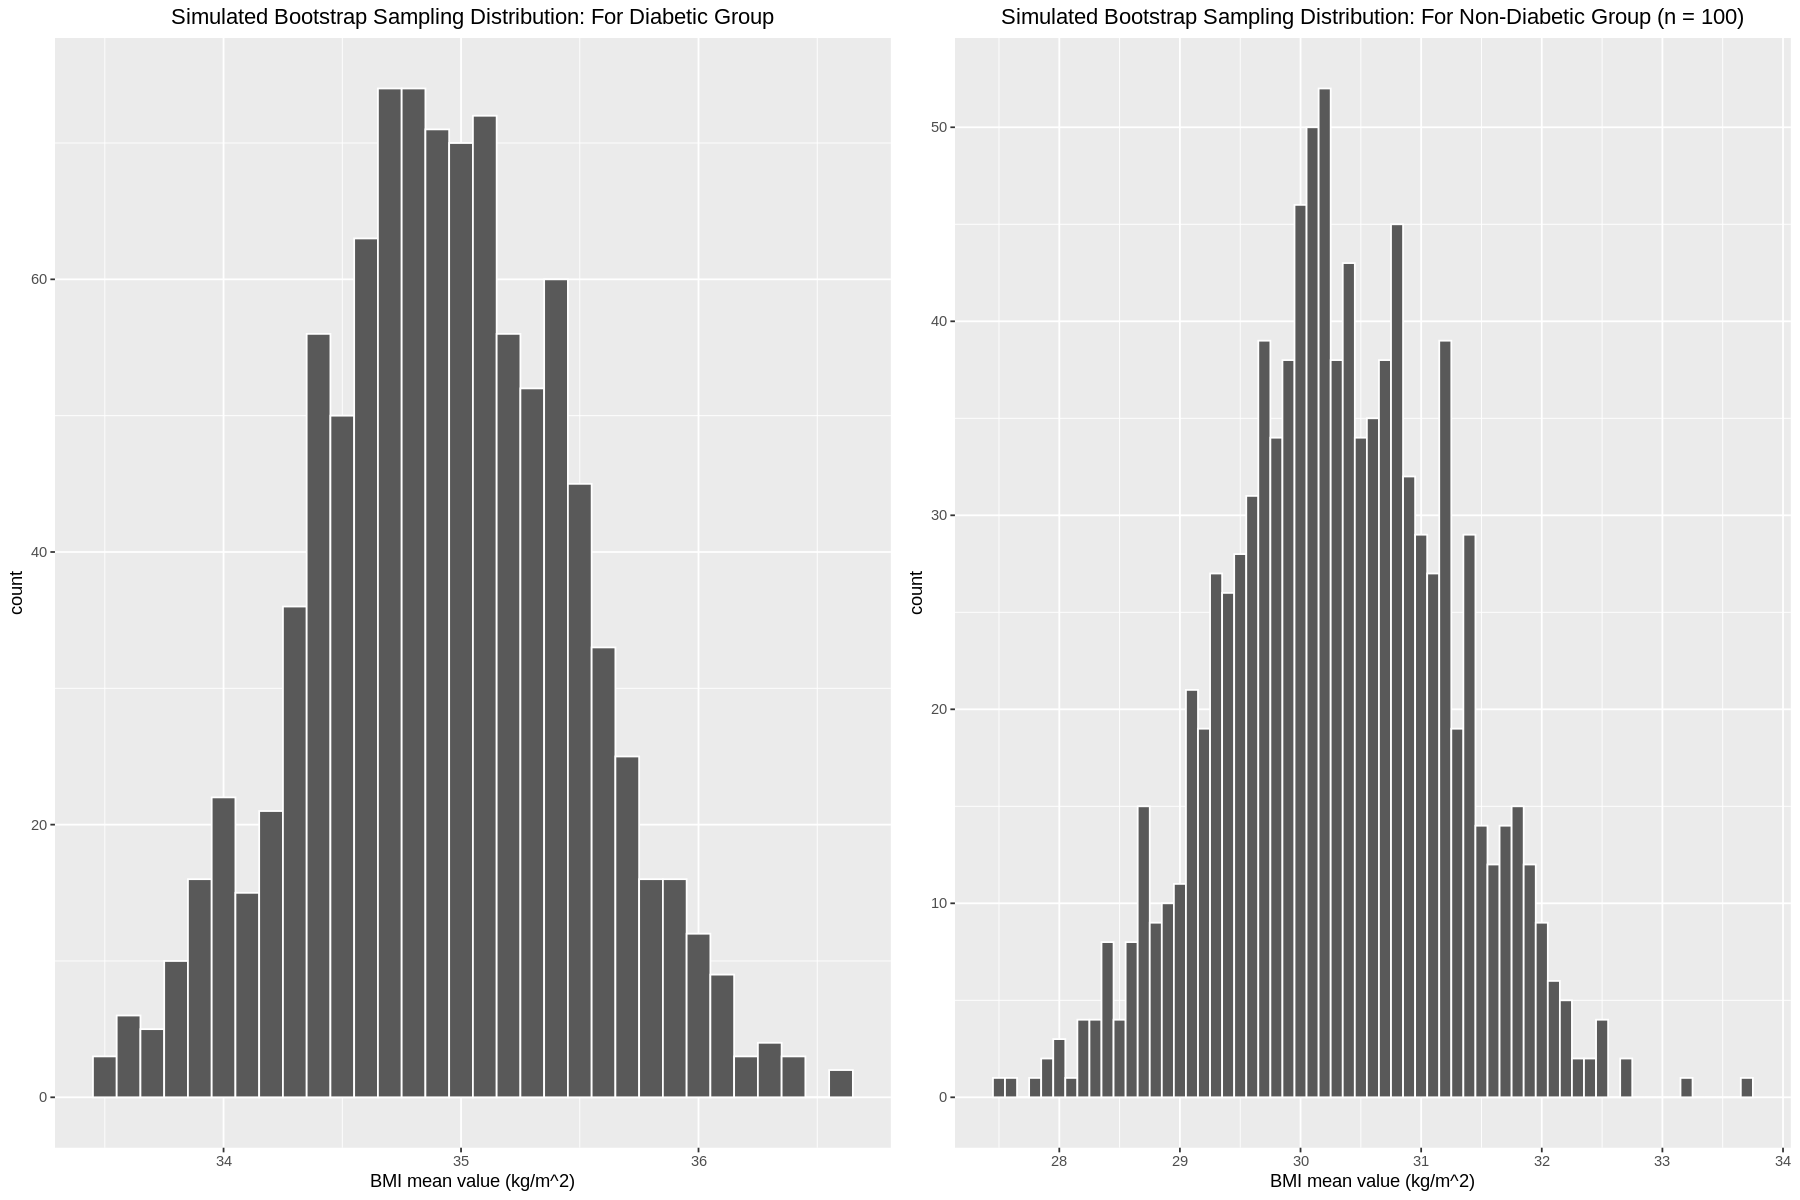

In [118]:
# BOOTSTRAP SAMPLING DISTRIBUTION

     # For : diabetic_group : We created 1000 bootstrap samples based on this single sample, and found the mean bmi value for each sample 

    bootstrap_diabetic <- sample_diabetic %>%
        rep_sample_n(size=100, reps=1000, replace=TRUE) %>%
        group_by(replicate) %>%
        summarize(mean_bmi = mean(bmi)) %>%
        select(mean_bmi)

        ## Histogram : Simulated BOOTSTRAP SAMPLING Distribution <diabetic>

        diabetic_boot_hist <- bootstrap_diabetic %>%
            ggplot(aes(x=mean_bmi))+
            geom_histogram(binwidth=0.1, color="white")+
            labs(x="BMI mean value (kg/m^2)")+
            ggtitle("Simulated Bootstrap Sampling Distribution: For Diabetic Group (n = 100)") +
            scale_x_continuous(breaks=seq(0,50, 1)) +
            theme(plot.title = element_text(hjust = 0.5)) 


     # For : non-diabetic_group : We created 1000 bootstrap samples based on this single sample, and found the mean bmi value for each sample 

        bootstrap_nondiabetic <- sample_nondiabetic %>%
            rep_sample_n(size=100, reps=1000, replace=TRUE) %>%
            group_by(replicate) %>%
            summarize(mean_bmi = mean(bmi)) %>%
            select(mean_bmi)

        ## Histogram : Simulated BOOTSTRAP SAMPLING Distribution <non-diabetic>

        nondiabetic_boot_hist <- bootstrap_nondiabetic %>%
            ggplot(aes(x=mean_bmi))+
            geom_histogram(binwidth=0.1, color="white")+
            labs(x="BMI mean value (kg/m^2)")+
            ggtitle("Simulated Bootstrap Sampling Distribution: For Non-Diabetic Group (n = 100)") +
            scale_x_continuous(breaks=seq(0,50, 1)) +
            theme(plot.title = element_text(hjust = 0.5)) 

# Histogram of BOOTSTRAP SAMPLING distribution
plot_grid(diabetics_boot_hist, nondiabetic_boot_hist)

In [217]:
# We found the BMI value in confidence interval of non-diabetic group is indeed lower than that of diabetic group.
# The difference in mean (by how much, and regarding how much confidence and significant our result is) will be study further in our analysis. 

## Method/Plan

Bootstrapping and hypothesis testing via randomization will be used to conduct this inferential study. Let m1 be the mean BMI value for females with diabetes, and m2 be the mean BMI value for females without diabetes. We want to test:


<center>
$H_0: m_{1} = m_{2}$ 
and
$H_a: m_{1} > m_{2}$
</center>

This report is reliable because a random sample of size 100 was created using the R programming language. The observed bootstrap sampling distribution above is symmetrical and normal, implying that our sample size is sufficient. Thus, this signifies our sample is both representative of the population and unbiased. As a result, the estimate's result is likely generalizable to the broader population.
 
However, the plots and estimates produced are not enough to give to a stakeholder. Firstly, there is some degree of ambiguity as this study infers the population based on sample data. Therefore, to address this gap, this study would provide a broader confidence interval - with a 95% confidence level - to ensure the true difference in means is included, as well as correlated margin of error. Secondly, to make sure the analysis result is relatively replicable, our study will provide a p-value at the 5% significance level in our hypothesis test.

We predict that people with diabetes have higher average (mean) BMI than those who do not have diabetes. In other words, any increase in BMI above normal weight levels is associated with an increased risk of being diagnosed as having complications of diabetes mellitus. However, not all overweight or obese patients had these metabolic diseases and not all with these conditions were overweight or obese.

Understanding the link between body weight and metabolic illnesses is essential to comprehending the pathophysiological mechanisms that underlie these diseases. Given the considerable health and financial costs associated with diabetes, our findings also have important policy-forming formulations, which help improve early evaluation and management of risk factors leading to Diabetes.

Future studies may investigate the effect of abdominal obesity on diabetes, as well as the relationship between food environment and diabetes. One could compare the average amount of fast-food consumption of people with diabetes to those who do not have diabetes. A longitudinal experiment on diabetic patients could also provide a better understanding of how the effects of rising BMI on the likelihood of diabetes change overtime.


## References

Huang, J. (2015). Commentary on “Relation between BMI and Diabetes Mellitus and Its Complications among US Older Adults”. Southern Medical Journal, 108 (1), 37-38. doi: 10.14423/SMJ.0000000000000215.

Gray, N. , Picone, G. , Sloan, F. & Yashkin, A. (2015). Relation between BMI and Diabetes Mellitus and Its Complications among US Older Adults. Southern Medical Journal, 108 (1), 29-36. doi: 10.14423/SMJ.0000000000000214.

Namdev, P. (2018, March 25). Diabetes_dataset. Kaggle. Retrieved July 21, 2022, from https://www.kaggle.com/datasets/pushprajnamdev/diabetes-dataset?resource=download&select=diabetes.csv
